In [1]:
import pandas as pd 
import geopandas as gpd
from glob import glob
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
filepath = glob("/home/alex/data/la-metro-bike-share/*.csv")
dataframes = [pd.read_csv(f, low_memory=False) for f in filepath]
df = pd.concat(dataframes)
print(df.shape)
df.head()

(1860256, 18)


,trip_id,duration,start_time,end_time,start_station,start_lat,start_lon,end_station,end_lat,end_lon,bike_id,plan_duration,trip_route_category,passholder_type,bike_type,start_station_id,end_station_id,Unnamed: 0
0,124657107,5,7/1/2019 0:04,7/1/2019 0:09,4312.0,34.066990,-118.290878,4410.0,34.063351,-118.296799,6168,30.0,One Way,Monthly Pass,standard,NaN,NaN,NaN
1,124657587,9,7/1/2019 0:07,7/1/2019 0:16,3066.0,34.063389,-118.236160,3066.0,34.063389,-118.236160,17584,30.0,Round Trip,Monthly Pass,electric,NaN,NaN,NaN
2,124658068,5,7/1/2019 0:20,7/1/2019 0:25,4410.0,34.063351,-118.296799,4312.0,34.066990,-118.290878,18920,30.0,One Way,Monthly Pass,electric,NaN,NaN,NaN
3,124659747,20,7/1/2019 0:44,7/1/2019 1:04,3045.0,34.028511,-118.256668,4275.0,34.012520,-118.285896,6016,1.0,One Way,Walk-up,standard,NaN,NaN,NaN
4,124660227,27,7/1/2019 0:44,7/1/2019 1:11,3035.0,34.048401,-118.260948,3049.0,34.056969,-118.253593,5867,30.0,One Way,Monthly Pass,standard,NaN,NaN,NaN


In [3]:
def crop_trips_by_coordinates(dataframe):
    dataframe = dataframe[dataframe["start_lat"] > 33].copy()
    dataframe = dataframe[dataframe["end_lat"] > 33].copy()
    dataframe = dataframe[dataframe["start_lon"] < -116].copy()
    dataframe = dataframe[dataframe["end_lon"] < -116].copy()
    return dataframe

df_crop = crop_trips_by_coordinates(df).copy()

def generate_datetime_features(dataframe):
    dataframe["start_time"] = pd.to_datetime(dataframe["start_time"])
    dataframe["end_time"] = pd.to_datetime(dataframe["end_time"])
    dataframe["trip_duration_in_minutes"] = dataframe["end_time"] - dataframe["start_time"]
    df = dataframe[dataframe["trip_duration_in_minutes"] > pd.Timedelta(minutes=0)].copy()
    df = df[df["trip_duration_in_minutes"] < pd.Timedelta(hours=24)]
    df["trip_duration_in_minutes"] = df["trip_duration_in_minutes"] / pd.Timedelta(minutes=1)
    df["year"] = df["start_time"].dt.year
    df["month"] = df["start_time"].dt.month
    df["day_of_week"] = df["start_time"].dt.dayofweek
    df["hour"] = df["start_time"].dt.hour
    df = df.sort_values("start_time")
    return df

df_datetime = generate_datetime_features(df_crop)

df_for_processing = df_datetime[["trip_id","start_time","end_time","start_lat","start_lon","end_lat","end_lon","bike_id","trip_route_category","passholder_type","trip_duration_in_minutes","year","month","day_of_week","hour"]].copy()

def add_coordinate_features(dataframe):
    df = dataframe.copy()
    df['StartCoordinate'] = list(zip(df.start_lat, df.start_lon))
    df['EndCoordinate'] = list(zip(df.end_lat, df.end_lon))
    return df

df_for_processing = add_coordinate_features(df_for_processing)

simplified_dictionary = {"Annual Pass": "Subscriber", "Flex Pass":"Subscriber", "Monthly Pass": "Subscriber", "One Day Pass": "Customer", "Walk-up":"Customer"}

df_for_processing["UserType"] = df_for_processing["passholder_type"].map(simplified_dictionary)



In [4]:
# function to calculate Cohen's d for independent samples
def cohen_d(d1, d2):
    # calculate the size of samples
    n1, n2 = len(d1), len(d2)
    # calculate the variance of the samples
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    # calculate the pooled standard deviation
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    # calculate the means of the samples
    u1, u2 = np.mean(d1), np.mean(d2)
    # calculate the effect size
    return np.absolute((u1 - u2) / s)

def sample_confidence_intervals(sample, confidence=0.95):
    sample = np.array(sample)
  # Remove NaN values
    sample = sample[~np.isnan(sample)]
  # Sample mean
    mean = np.mean(sample)
  # Sample size
    n = len(sample)
  # Standard error
    stderr = np.std(sample, ddof=1) / np.sqrt(n)
  # T-statistic that contains 95% of possible sample means within its bounds
    t = stats.t.ppf((1 + confidence) / 2.0, n-1)
  # Margin of error 
    margin_of_error = t * stderr

    return mean, margin_of_error


In [8]:
df_for_processing.groupby("UserType")["trip_duration_in_minutes"].mean()

UserType
Customer      48.258638
Subscriber    13.599370
Name: trip_duration_in_minutes, dtype: float64

In [17]:
customer_sample = df_for_processing[df_for_processing["UserType"] ==  "Customer"]["trip_duration_in_minutes"].sample(50000)
subscriber_sample = df_for_processing[df_for_processing["UserType"] ==  "Subscriber"]["trip_duration_in_minutes"].sample(50000)


In [18]:
sample_confidence_intervals(customer_sample)

(48.88423233333334, 0.9184515340059345)

In [19]:
sample_confidence_intervals(subscriber_sample)

(14.027503333333332, 0.37184170348952983)

In [20]:
labels = ["Customer", "Subscriber"]

means = [sample_confidence_intervals(customer_sample)[0], 
         sample_confidence_intervals(subscriber_sample)[0]]

margin_of_error = [sample_confidence_intervals(customer_sample)[1], 
                   sample_confidence_intervals(subscriber_sample)[1]]



In [25]:
means_df = pd.DataFrame([means, margin_of_error], columns=labels).T

means_df.columns = ["Mean", "Margin of error"]

#means_df = means_df.loc[labels]

moe = means_df["Margin of error"].values

means_df

,Mean,Margin of error
Customer,48.884232,0.918452
Subscriber,14.027503,0.371842


In [38]:
means_df["pretty_label"] = np.round(means_df["Mean"]).astype(int).astype(str) + " ± " + np.round(means_df["Margin of error"],1).astype(str)

In [39]:
means_df["pretty_label"] = means_df["pretty_label"].astype(str)

In [40]:
means_df

,Mean,Margin of error,pretty_label
Customer,48.884232,0.918452,49 ± 0.9
Subscriber,14.027503,0.371842,14 ± 0.4


In [41]:
y = means_df["pretty_label"]


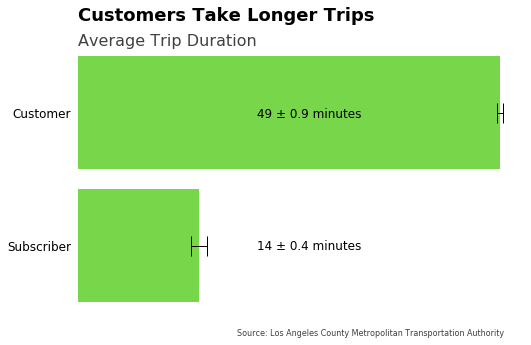

In [336]:
fig, ax = plt.subplots(figsize=(8,6))
means_df["Mean"].sort_values().plot.barh(xerr=moe, color="#78d64b",width=0.85, error_kw=dict(ecolor='black', lw=1, capsize=10, capthick=1))


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)



ax.yaxis.set_tick_params(labelsize=12)

ax.text(0.4,0.275 , y[1] + " minutes", size=12,weight="500",alpha=1, transform=ax.transAxes)
ax.text(0.4,0.695 , y[0] + " minutes", size=12,weight="500",alpha=1, transform=ax.transAxes)

plt.suptitle("Customers Take Longer Trips", size=18, y=1.05, ha="left", x=0, fontweight="bold", transform=ax.transAxes)
plt.title("Average Trip Duration", size=16, alpha=0.75, loc="left", y= 0.925, x=0, transform=ax.transAxes)

plt.subplots_adjust(top=0.85)

plt.tick_params(bottom=False, left=False, labelbottom=False)

#plt.axhline(y=-0.55, xmin=0, xmax=0.95, lw=1, color="black", alpha=0.5)
ax.text(x=0.355,y=0, s="Source: Los Angeles County Metropolitan Transportation Authority", size=8,weight="400",alpha=0.75, transform=ax.transAxes)



#plt.show()

plt.savefig("/home/alex/data/la-metro-bike-share/metro-bike-share-triplengths.png", dpi=300)

In [128]:
df_for_processing.head()

,trip_id,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,passholder_type,trip_duration_in_minutes,year,month,day_of_week,hour,StartCoordinate,EndCoordinate,UserType
0,1912818,2016-07-07 04:17:00,2016-07-07 04:20:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,3.0,2016,7,3,4,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber
0,1912818,2016-07-07 04:17:00,2016-07-07 04:20:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,3.0,2016,7,3,4,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber
1,1919661,2016-07-07 06:00:00,2016-07-07 06:33:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,33.0,2016,7,3,6,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber
1,1919661,2016-07-07 06:00:00,2016-07-07 06:33:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,33.0,2016,7,3,6,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber
2,1933383,2016-07-07 10:32:00,2016-07-07 10:37:00,34.052898,-118.24156,34.052898,-118.24156,5861,Round Trip,Flex Pass,5.0,2016,7,3,10,"(34.0528984, -118.24156)","(34.0528984, -118.24156)",Subscriber


In [129]:
df_for_processing['DayType'] = df_for_processing['day_of_week'].apply(lambda x: 'Weekday' if x <= 4 else 'Weekend')

df_for_processing.head()

,trip_id,start_time,end_time,start_lat,start_lon,end_lat,end_lon,bike_id,trip_route_category,passholder_type,trip_duration_in_minutes,year,month,day_of_week,hour,StartCoordinate,EndCoordinate,UserType,DayType
0,1912818,2016-07-07 04:17:00,2016-07-07 04:20:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,3.0,2016,7,3,4,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber,Weekday
0,1912818,2016-07-07 04:17:00,2016-07-07 04:20:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,3.0,2016,7,3,4,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber,Weekday
1,1919661,2016-07-07 06:00:00,2016-07-07 06:33:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,33.0,2016,7,3,6,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber,Weekday
1,1919661,2016-07-07 06:00:00,2016-07-07 06:33:00,34.056610,-118.23721,34.056610,-118.23721,6281,Round Trip,Monthly Pass,33.0,2016,7,3,6,"(34.0566101, -118.23721)","(34.0566101, -118.23721)",Subscriber,Weekday
2,1933383,2016-07-07 10:32:00,2016-07-07 10:37:00,34.052898,-118.24156,34.052898,-118.24156,5861,Round Trip,Flex Pass,5.0,2016,7,3,10,"(34.0528984, -118.24156)","(34.0528984, -118.24156)",Subscriber,Weekday


In [130]:
sample_of_weekdays = df_for_processing[df_for_processing["DayType"] == "Weekday"]["trip_duration_in_minutes"].sample(50000)

sample_of_weekends = df_for_processing[df_for_processing["DayType"] == "Weekend"]["trip_duration_in_minutes"].sample(50000)


stats.ttest_ind(sample_of_weekdays, sample_of_weekends)

Ttest_indResult(statistic=-29.381134436372953, pvalue=6.125365751799963e-189)

In [131]:
cohen_d(sample_of_weekdays, 
        
        sample_of_weekends)

0.1858226101170921

In [138]:
subscribers_df = df_for_processing[df_for_processing["UserType"] == "Subscriber"].copy()
customers_df = df_for_processing[df_for_processing["UserType"] == "Customer"].copy()

In [139]:
sample_of_customer_weekdays = subscribers_df[subscribers_df["DayType"] == "Weekday"]["trip_duration_in_minutes"].sample(50000)
sample_of_customer_weekends = subscribers_df[subscribers_df["DayType"] == "Weekend"]["trip_duration_in_minutes"].sample(50000)

sample_of_subscriber_weekdays = customers_df[customers_df["DayType"] == "Weekday"]["trip_duration_in_minutes"].sample(50000)
sample_of_subscriber_weekends = customers_df[customers_df["DayType"] == "Weekend"]["trip_duration_in_minutes"].sample(50000)

In [140]:
stats.ttest_ind(sample_of_customer_weekdays, sample_of_customer_weekends)

Ttest_indResult(statistic=-16.092772367114822, pvalue=3.39385404907888e-58)

In [141]:
cohen_d(sample_of_customer_weekdays, 
        
        sample_of_customer_weekends)

0.10177962909340446

In [142]:
stats.ttest_ind(sample_of_subscriber_weekdays, sample_of_subscriber_weekends)

Ttest_indResult(statistic=-12.060987800287672, pvalue=1.7907658634873523e-33)

In [143]:
cohen_d(sample_of_subscriber_weekdays, 
        
        sample_of_subscriber_weekends)

0.07628038456082614

In [144]:
pd.crosstab(df_for_processing["UserType"], df_for_processing["DayType"], normalize="index")

DayType,Weekday,Weekend
UserType,,
Customer,0.599197,0.400803
Subscriber,0.807656,0.192344


In [154]:
observed = pd.crosstab(df_for_processing["UserType"], df_for_processing["DayType"]).values
chi2_stat, p_value, dof, expected = stats.chi2_contingency(observed)

print("chi2_stat:", chi2_stat)

print("p_value:",p_value)

print("dof:",dof)

print("expected:",expected)


chi2_stat: 92487.98487192241
p_value: 0.0
dof: 1
expected: [[476453.98838112 173720.01161888]
 [850552.01161888 310119.98838112]]


Given a $\chi^2$ statistic of 92487.98487192241, a $\text{p value}$ of 0.0, 1 degree of freedom, and a confidence interval of 95%, I reject the null hypothesis that user type and day type are independent. Instead I suggest the alternative hypothesis that user type and day type are not independent.

In [272]:
df_for_correlation = df_for_processing[["UserType","DayType"]].copy()
correlation_dictionary = {"Subscriber":1, "Customer":2, "Weekday":3, "Weekend":4}
df_for_correlation["UserType"] = df_for_correlation["UserType"].map(correlation_dictionary)
df_for_correlation["DayType"] = df_for_correlation["DayType"].map(correlation_dictionary)

In [273]:
df_for_correlation.corr()

,UserType,DayType
UserType,1.000000,0.225998
DayType,0.225998,1.000000


In [204]:
crosstab_df = pd.crosstab(df_for_processing["UserType"], df_for_processing["DayType"], normalize="index")
crosstab_df

DayType,Weekday,Weekend
UserType,,
Customer,0.599197,0.400803
Subscriber,0.807656,0.192344


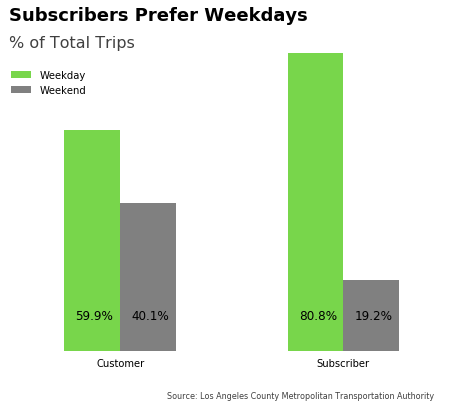

In [335]:
fig, ax = plt.subplots(figsize=(8,6))

crosstab_df.plot(kind="bar", color=["#78d64b","#808080"], ax=ax)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.tick_params(bottom=False, left=False, labelbottom=True, labelleft=False)

plt.xticks(rotation=0)
plt.xlabel(" ")

plt.suptitle("Subscribers Prefer Weekdays", size=18, y=1.1, ha="left", x=0, fontweight="bold", transform=ax.transAxes)
plt.title("% of Total Trips", size=16,alpha=0.75, loc="left", y= .97, x=0, transform=ax.transAxes)

#plt.axhline(y=-0.5, xmin=0, xmax=0.95, lw=1, color="black", alpha=0.5)
ax.text(x=0.355,y=-0.15, s="Source: Los Angeles County Metropolitan Transportation Authority", size=8,weight="400",alpha=0.75, transform=ax.transAxes)

plt.subplots_adjust(top=0.85)

ax.text(0.15,0.1 , str(np.round(crosstab_df.iloc[0,0]*100, 1)) + "%", size=12,weight="500",alpha=1, transform=ax.transAxes)
ax.text(0.275,0.1 , str(np.round(crosstab_df.iloc[0,1]*100, 1)) + "%", size=12,weight="500",alpha=1, transform=ax.transAxes)

ax.text(0.65,0.1 , str(np.round(crosstab_df.iloc[1,0]*100, 1)) + "%", size=12,weight="500",alpha=1, transform=ax.transAxes)
ax.text(0.775,0.1 , str(np.round(crosstab_df.iloc[1,1]*100, 1)) + "%", size=12,weight="500",alpha=1, transform=ax.transAxes)

plt.legend(["Weekday", "Weekend"], frameon=False, bbox_to_anchor=(0.275, 0.795),bbox_transform=plt.gcf().transFigure)

plt.savefig("/home/alex/data/la-metro-bike-share/metro-bike-share-daytypes.png", dpi=300)

In [287]:
crosstab_hod_df = pd.crosstab(df_for_processing["UserType"], df_for_processing["hour"], normalize="index")*100

crosstab_hod_df

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
UserType,,,,,,,,,,,,,,,,,,,,,
Customer,1.422081,0.999425,0.586612,0.195025,0.142423,0.240859,0.533703,1.255356,2.622067,3.822054,...,8.680446,8.684752,8.698595,8.181810,7.148856,5.862431,4.238250,3.532285,2.870616,2.107128
Subscriber,0.920674,0.583800,0.392531,0.251234,0.281561,0.575012,2.177704,4.930592,7.031099,5.540411,...,5.396012,5.856263,7.733623,9.682667,8.131324,6.238627,4.595958,3.252598,2.230777,1.510504


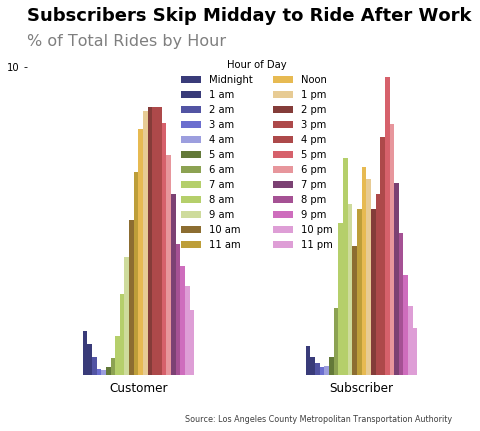

In [338]:
fig, ax = plt.subplots(figsize=(8,6))



crosstab_hod_df.plot(kind="bar", ax=ax, cmap="tab20b")
plt.xticks(rotation=0, size=12)
plt.yticks([10])
plt.subplots_adjust(top=0.85)
plt.xlabel(" ")
plt.tick_params(bottom=False, left=True, labelbottom=True, labelleft=True)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

plt.suptitle("Subscribers Skip Midday to Ride After Work", size=18, y=1.175, ha="left", x=0, fontweight="bold", transform=ax.transAxes)
plt.title("% of Total Rides by Hour", size=16, alpha=0.5, loc="left", color="black", y= 1.05, x=0, transform=ax.transAxes)

ax.text(x=0.355,y=-0.15, s="Source: Los Angeles County Metropolitan Transportation Authority", size=8,weight="400",alpha=0.75, transform=ax.transAxes)
ax.legend(["Midnight", "1 am", "2 am", "3 am", "4 am", "5 am", "6 am", "7 am", "8 am", "9 am", "10 am", "11 am", "Noon", "1 pm", "2 pm", "3 pm", "4 pm", "5 pm", "6 pm", "7 pm", "8 pm", "9 pm", "10 pm", "11 pm"], frameon=False,fontsize=10, loc="upper center", ncol=2, title="Hour of Day", bbox_to_anchor=(0.525, 0.875),bbox_transform=plt.gcf().transFigure)



plt.show()
#plt.savefig("metro-bike-share-weekly-trends.png", dpi=500)

Hypothesis testing

Null-hypothesis: Customer trip durations are equal to subscriber trip durations.

$H_0: \bar{x}_{Customer} = \bar{x}_{Subscriber}$

Alternative hypothesis: Customer trip durations are not equal to subscriber trip durations

$H_a: \bar{x}_{Customer} \neq \bar{x}_{Subscriber}$

Confidence level: 95%



In [339]:
sample_of_subscribers = df_for_processing[df_for_processing["UserType"] == "Subscriber"]["trip_duration_in_minutes"].sample(50000)

sample_of_customers = df_for_processing[df_for_processing["UserType"] == "Customer"]["trip_duration_in_minutes"].sample(50000)


stats.ttest_ind(sample_of_subscribers, sample_of_customers)
                
                

Ttest_indResult(statistic=-69.2646126319151, pvalue=0.0)

In [6]:
cohen_d(sample_of_subscribers, 
        
        sample_of_customers)

0.43690376183403073

In [7]:
sample_confidence_intervals(sample_of_subscribers)

(13.976395333333334, 0.365854843417433)

In [8]:
sample_confidence_intervals(sample_of_customers)

(48.91490866666666, 0.9213227275431897)

Hypothesis testing

Null-hypothesis: Weekday trip durations are equal to weekend trip durations.

$H_0: \bar{x}_{Weekday} = \bar{x}_{Weekend}$

Alternative hypothesis: Weekday trip durations are not equal to weekend trip durations

$H_a: \bar{x}_{Weekday} \neq \bar{x}_{Weekend}$

Confidence level: 95%



In [10]:
df_for_processing['DayType'] = df_for_processing['day_of_week'].apply(lambda x: 'Weekday' if x <= 4 else 'Weekend')

In [11]:
sample_of_weekdays = df_for_processing[df_for_processing["DayType"] == "Weekday"]["trip_duration_in_minutes"].sample(50000)

sample_of_weekends = df_for_processing[df_for_processing["DayType"] == "Weekend"]["trip_duration_in_minutes"].sample(50000)


stats.ttest_ind(sample_of_weekdays, sample_of_weekends)
                
                

Ttest_indResult(statistic=-27.36407046679856, pvalue=2.9741188067674656e-164)

In [12]:
cohen_d(sample_of_weekdays, 
        
        sample_of_weekends)

0.1730655774568608

In [13]:
sample_confidence_intervals(sample_of_weekdays)

(22.702348999999998, 0.5896862081638822)

In [14]:
sample_confidence_intervals(sample_of_weekends)

(35.670805333333334, 0.7177146794824898)

Null hypothesis: User type (Customer or Subscriber) and day type (Weekday or Weekend) are independent.

Alternative hypothesis: User type and day type are not independent.

Confidence interval: 95%